# Bitcoin Price Prediction - Documentation
## BS Data Science Project - Recurrent Bitcoin Network

This notebook contains a brief documentation on retrieving data from [Messari](https://messari.io/) through its web [API](https://messari.io/api/docs).

### Prerequesites

Before running this notebook, several python packages are needed to be installed as shown in the following cell. In addition, changing of working directory within the local repository was done.

### License

This notebook is licensed under GNU General Public License v3.0. See `LICENSE` in the project root for details.

In [1]:
# Built-in packages
import os
from datetime import datetime

In [2]:
os.chdir('../src')

In [3]:
# Packages to be installed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# Local python functions
import collect
import pipeline

In [4]:
%load_ext tensorboard

In [5]:
# Notebook Execution Time
print('Current time: {}'.format(datetime.now()))

Current time: 2022-03-07 12:28:01.288863


In [6]:
# Use this cell if you intend to apply your Messari API key
# os.environ['MESSARI_API_KEY'] = <insert_key_here>

In [7]:
'MESSARI_API_KEY' in os.environ

False

In [8]:
collector = collect.MessariCollector(api_key=os.getenv('MESSARI_API_KEY'))

### Data
The expected data would be a data frame of time series data denoted by its columns and it would be splitted, normalized, and be fed for model training and testing. In this project, we would only use daily time series data from 2016 to 2020 as the training set, while 2021 data would be used as a test set.

The following table below shows a sample of metrics to be used as features for Bitcoin price forecasting, along with their descriptions and sources. For full list of metrics, see `metrics.csv`.

In [9]:
df_metrics = collector.get_metrics()
df_metrics.data.to_csv('../raw/metrics.csv')
df_metrics.data

,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
addr.act.rcv.cnt,Active Addresses Count (Received),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.act.sent.cnt,Active Addresses Count (Sent),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.001.ntv.cnt,Addresses with balance greater than 0.001 nati...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.01.ntv.cnt,Addresses with balance greater than 0.01 nativ...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
...,...,...,...,...,...,...
utxo.age.med,Median UTXO Age,The median age in full days of all unspent tra...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.age.val.avg,Value-weighted Average UTXO Age,The value-weighted average age in full days of...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.cnt,UTXO Count,The sum count of unspent transaction outputs t...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io


In [10]:
btc_metrics = df_metrics.data.copy()
btc_metrics = btc_metrics[btc_metrics['role_restriction'].isna()]

In [11]:
metrics_to_remove = [
    'blk.size.bytes.avg', 'cg.sply.circ', 'exch.flow.in.ntv',
    'exch.flow.in.ntv.incl', 'exch.flow.in.usd', 'exch.flow.out.ntv',
    'exch.flow.out.ntv.incl', 'exch.flow.out.usd', 'exch.sply',
    'fees.ntv', 'mcap.dom', 'min.rev.ntv', 'min.rev.usd', 'new.iss.ntv',
    'reddit.subscribers', 'reddit.active.users', 'sply.circ', 'sply.out',
    'sply.liquid', 'sply.total.iss.ntv', 'txn.fee.avg.ntv',
    'txn.fee.med.ntv', 'txn.tfr.avg.ntv', 'txn.tfr.erc20.cnt',
    'txn.tfr.erc721.cnt', 'txn.tfr.val.adj.ntv', 'txn.tfr.val.med.ntv',
    'txn.tfr.val.ntv', 'txn.tsfr.val.adj'
]
btc_metrics.drop(metrics_to_remove, inplace=True)
btc_metrics.to_csv('../raw/bitcoin_metrics.csv')

In [12]:
print(f'Number of metrics: {btc_metrics.shape[0]}')
btc_metrics

Number of metrics: 30


,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
blk.cnt,Block Count,The sum count of blocks created each day,1d,NaN,Coinmetrics,https://coinmetrics.io
blk.size.byte,Block Size (bytes),The sum of the size (in bytes) of all blocks c...,1d,NaN,Coinmetrics,https://coinmetrics.io
daily.shp,Sharpe Ratio,The Sharpe ratio (performance of the asset com...,1d,NaN,Kaiko,https://www.kaiko.com/
daily.vol,Volatility,The annualized standard-deviation of daily ret...,1d,NaN,Kaiko,https://www.kaiko.com/
diff.avg,Average Difficulty,The mean difficulty of finding a hash that mee...,1d,NaN,Coinmetrics,https://coinmetrics.io
exch.flow.in.usd.incl,Deposits on Exchanges - Inclusive,The sum USD value sent to exchanges that inter...,1d,NaN,Coinmetrics,https://coinmetrics.io
exch.flow.out.usd.incl,Withdrawals from Exchanges - Inclusive,The sum USD value withdrawn from exchanges tha...,1d,NaN,Coinmetrics,https://coinmetrics.io
exch.sply.usd,Supply on Exchanges,The sum USD value of all native units held in ...,1d,NaN,Coinmetrics,https://coinmetrics.io


In [13]:
# Data Sources
btc_metrics['source_name'].unique()

array(['Coinmetrics', 'Kaiko', 'Messari', 'CoinGecko'], dtype=object)

### Retrieve Time Series Data

In this section, we would retrieve time series data with the given metrics retrieved above. A script was implemented to automate the data collection process.

In [14]:
try:
    train_df = pd.read_csv('../raw/train.csv')
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    train_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2016-01-01',
        end='2020-12-31'
    )
    train_df = pd.concat(
        [resp.get_melt_data() for resp in train_raw],
        ignore_index=True
    )
    train_df.to_csv('../raw/train.csv', index=False)

In [15]:
try:
    test_df = pd.read_csv('../raw/test.csv')
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    test_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2021-01-01',
        end='2021-06-30'
    )
    test_df = pd.concat(
        [resp.get_melt_data() for resp in test_raw],
        ignore_index=True
    )
    test_df.to_csv('../raw/test.csv', index=False)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69426 entries, 0 to 69425
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  69426 non-null  object 
 1   metric     69426 non-null  object 
 2   submetric  69426 non-null  object 
 3   value      69426 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6878 non-null   object 
 1   metric     6878 non-null   object 
 2   submetric  6878 non-null   object 
 3   value      6878 non-null   float64
dtypes: float64(1), object(3)
memory usage: 215.1+ KB


### Data Transformation

We would convert the given time series data from a long format to a wide format.

In [18]:
wide_train = train_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_train = wide_train.pop('price')

In [19]:
wide_test = test_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_test = wide_test.pop('price')

In [20]:
wide_train

metric         act.addr.cnt     blk.cnt blk.size.byte  daily.shp             \
submetric  active_addresses block_count   block_count sharpe_1yr sharpe_30d   
timestamp                                                                     
2016-01-01         316781.0       135.0    66544854.0   0.869196   3.254284   
2016-01-02         417966.0       145.0    83567789.0   0.903431   3.742549   
2016-01-03         398443.0       145.0    82041255.0   0.885630   3.463730   
2016-01-04         413159.0       181.0    99672880.0   1.075561   3.520499   
2016-01-05         435291.0       157.0   100644706.0   1.157387   2.312140   
...                     ...         ...           ...        ...        ...   
2020-12-27        1049825.0       148.0   193716651.0   1.983447   8.207496   
2020-12-28        1154354.0       160.0   206766595.0   1.994093   7.835167   
2020-12-29        1146131.0       152.0   194179955.0   1.987428   6.938161   
2020-12-30        1221579.0       172.0   215838093.0   2.077002   7.061308   
2020-12-31        1193822.0       166.0   213533786.0   2.081395   8.284225   

metric                                daily.vol                                \
submetric  sharpe_3yr sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                                       
2016-01-01   1.604864   3.685772       0.685757       0.640308       1.028978   
2016-01-02   1.609291   3.635713       0.685251       0.631588       1.028922   
2016-01-03   1.612791   3.592289       0.685339       0.633846       1.028857   
2016-01-04   1.612907   3.596404       0.675956       0.633926       1.028857   
2016-01-05   1.609834   3.442895       0.673562       0.592641       1.028863   
...               ...        ...            ...            ...            ...   
2020-12-27   0.326527   6.766483       0.752805       0.686434       0.769437   
2020-12-28   0.332238   6.742289       0.753484       0.690959       0.769680   
2020-12-29   0.380683   6.615674       0.753403       0.697172       0.766073   
2020-12-30   0.362164   7.173090       0.753598       0.647848       0.763810   
2020-12-31   0.381229   7.203934       0.755037       0.636090       0.764076   

metric      ...      nvt.adj.90d.ma      real.vol     sply.total.iss  \
submetric   ... nvt_adjusted_90d_ma        volume issuance_total_usd   
timestamp   ...                                                        
2016-01-01  ...           41.147256  2.099646e+07       1.467038e+06   
2016-01-02  ...           41.048731  1.393225e+07       1.574845e+06   
2016-01-03  ...           40.644184  2.396948e+07       1.559244e+06   
2016-01-04  ...           40.918827  2.528594e+07       1.961357e+06   
2016-01-05  ...           40.754906  1.956450e+07       1.698228e+06   
...         ...                 ...           ...                ...   
2020-12-27  ...          114.994093  1.043023e+10       2.444854e+07   
2020-12-28  ...          115.311281  5.653047e+09       2.703935e+07   
2020-12-29  ...          114.333016  5.558736e+09       2.586964e+07   
2020-12-30  ...          119.111340  7.442424e+09       3.100796e+07   
2020-12-31  ...          118.111923  7.007439e+09       3.011102e+07   

metric               txn.cnt         txn.fee.avg                txn.fee.med  \
submetric  transaction_count transaction_fee_avg transaction_fee_median_usd   
timestamp                                                                     
2016-01-01          124427.0            0.069424                   0.043468   
2016-01-02          147864.0            0.091773                   0.043444   
2016-01-03          145029.0            0.072584                   0.043014   
2016-01-04          178576.0            0.073746                   0.043345   
2016-01-05          183659.0            0.076591                   0.043267   
...                      ...                 ...                        ...   
2020-12-27          304240.0          

In [21]:
wide_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 33 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   (act.addr.cnt, active_addresses)                1827 non-null   float64
 1   (blk.cnt, block_count)                          1827 non-null   float64
 2   (blk.size.byte, block_count)                    1827 non-null   float64
 3   (daily.shp, sharpe_1yr)                         1827 non-null   float64
 4   (daily.shp, sharpe_30d)                         1827 non-null   float64
 5   (daily.shp, sharpe_3yr)                         1827 non-null   float64
 6   (daily.shp, sharpe_90d)                         1827 non-null   float64
 7   (daily.vol, volatility_1yr)                     1827 non-null   float64
 8   (daily.vol, volatility_30d)                     1827 non-null   float64
 9   (daily.vol, volatility_3yr)    

In [22]:
prices_train

submetric,close,high,low,open,volume
timestamp,,,,,
2016-01-01,433.960345,437.841344,426.068766,430.206620,2.099646e+07
2016-01-02,433.221343,436.820867,431.542401,434.015456,1.393225e+07
2016-01-03,429.132867,433.727409,422.757469,433.212063,2.396948e+07
2016-01-04,433.152291,435.231337,428.233668,429.401480,2.528594e+07
2016-01-05,432.001391,434.548442,428.386082,432.978697,1.956450e+07
...,...,...,...,...,...
2020-12-27,26250.457794,28375.198389,25748.450880,26453.928239,1.043023e+10
2020-12-28,27032.289152,27469.396137,26069.019129,26248.564564,5.653047e+09
2020-12-29,27360.005185,27387.310760,25832.269524,27036.832984,5.558736e+09


In [23]:
wide_test

metric         act.addr.cnt     blk.cnt blk.size.byte  daily.shp             \
submetric  active_addresses block_count   block_count sharpe_1yr sharpe_30d   
timestamp                                                                     
2021-01-01        1001890.0       149.0   200183875.0   2.155131   8.298569   
2021-01-02        1140633.0       151.0   210941948.0   2.227206   9.182984   
2021-01-03        1184688.0       158.0   202984712.0   2.227079  10.845058   
2021-01-04        1270082.0       173.0   228206364.0   2.147672   8.671640   
2021-01-05        1230529.0       157.0   202837860.0   2.147846   9.762872   
...                     ...         ...           ...        ...        ...   
2021-06-26         715801.0        89.0   125963998.0   1.878109  -1.705682   
2021-06-27         518219.0        58.0    82910666.0   1.970423  -0.152450   
2021-06-28         776365.0        88.0   120824022.0   1.998260   0.755840   
2021-06-29         792995.0        90.0   125757036.0   2.066747   1.160495   
2021-06-30         790273.0        88.0   119962693.0   2.013163   0.042696   

metric                                daily.vol                                \
submetric  sharpe_3yr sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                                       
2021-01-01   0.348882   7.383160       0.753934       0.631271       0.762070   
2021-01-02   0.393070   7.684719       0.760788       0.725350       0.765063   
2021-01-03   0.389926   7.769999       0.757727       0.657062       0.764035   
2021-01-04   0.316454   7.363521       0.760406       0.708616       0.761901   
2021-01-05   0.331617   7.770842       0.756858       0.676053       0.761347   
...               ...        ...            ...            ...            ...   
2021-06-26   0.741597  -1.913398       0.773250       0.977241       0.760603   
2021-06-27   0.786307  -1.819497       0.773300       0.955958       0.760265   
2021-06-28   0.800399  -1.709259       0.776642       0.983585       0.761453   
2021-06-29   0.815171  -1.422778       0.778148       0.994653       0.761873   
2021-06-30   0.797321  -1.619262       0.778176       0.982542       0.761832   

metric      ...      nvt.adj.90d.ma      real.vol     sply.total.iss  \
submetric   ... nvt_adjusted_90d_ma        volume issuance_total_usd   
timestamp   ...                                                        
2021-01-01  ...          117.977582  5.206879e+09       2.736077e+07   
2021-01-02  ...          125.420388  1.150113e+10       3.022141e+07   
2021-01-03  ...          128.553868  1.151527e+10       3.286186e+07   
2021-01-04  ...          120.732416  1.317324e+10       3.438607e+07   
2021-01-05  ...          127.138194  1.084223e+10       3.337543e+07   
...         ...                 ...           ...                ...   
2021-06-26  ...           46.681519  9.229162e+09       1.773919e+07   
2021-06-27  ...           50.807897  8.188253e+09       1.250860e+07   
2021-06-28  ...           50.839665  7.074091e+09       1.890690e+07   
2021-06-29  ...           53.298267  7.771038e+09       2.021275e+07   
2021-06-30  ...           52.204167  6.306070e+09       1.928601e+07   

metric               txn.cnt         txn.fee.avg                txn.fee.med  \
submetric  transaction_count transaction_fee_avg transaction_fee_median_usd   
timestamp                                                                     
2021-01-01          261318.0            5.470001                   1.834531   
2021-01-02          297595.0            8.820430                   4.604862   
2021-01-03          359641.0            7.865601                   4.082858   
2021-01-04          370865.0            9.393836                   4.959227   
2021-01-05          355008.0           10.937188                   5.911830   
...                      ...                 ...                        ...   
2021-06-26          180868.0          

In [24]:
wide_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 2021-01-01 to 2021-06-30
Data columns (total 33 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   (act.addr.cnt, active_addresses)                181 non-null    float64
 1   (blk.cnt, block_count)                          181 non-null    float64
 2   (blk.size.byte, block_count)                    181 non-null    float64
 3   (daily.shp, sharpe_1yr)                         181 non-null    float64
 4   (daily.shp, sharpe_30d)                         181 non-null    float64
 5   (daily.shp, sharpe_3yr)                         181 non-null    float64
 6   (daily.shp, sharpe_90d)                         181 non-null    float64
 7   (daily.vol, volatility_1yr)                     181 non-null    float64
 8   (daily.vol, volatility_30d)                     181 non-null    float64
 9   (daily.vol, volatility_3yr)     

In [25]:
prices_test

submetric,close,high,low,open,volume
timestamp,,,,,
2021-01-01,29402.176951,29674.366390,28692.320100,28963.116282,5.206879e+09
2021-01-02,32200.200909,33268.527789,29022.584583,29394.914671,1.150113e+10
2021-01-03,33061.908711,34810.548275,31984.603073,32209.643507,1.151527e+10
2021-01-04,32013.657608,33686.591916,27902.210046,32979.561700,1.317324e+10
2021-01-05,34033.028441,34495.109124,29915.527058,31983.572856,1.084223e+10
...,...,...,...,...,...
2021-06-26,32291.059871,32720.139267,30159.355157,31627.640411,9.229162e+09
2021-06-27,34709.644610,34774.050537,32004.908689,32177.703946,8.188253e+09
2021-06-28,34495.235345,35307.183050,33870.570752,34716.047617,7.074091e+09


### Exploratory Data Analysis

In [26]:
wide_train.describe()

metric        act.addr.cnt      blk.cnt blk.size.byte    daily.shp  \
submetric active_addresses  block_count   block_count   sharpe_1yr   
count         1.827000e+03  1827.000000  1.827000e+03  1827.000000   
mean          7.097668e+05   149.278051  1.447808e+08     1.239195   
std           1.763584e+05    16.075478  2.893240e+07     1.156953   
min           3.167810e+05    80.000000  6.654485e+07    -1.925901   
25%           5.829215e+05   139.000000  1.223714e+08     0.568562   
50%           6.896430e+05   149.000000  1.437433e+08     1.336053   
75%           8.130080e+05   160.000000  1.639708e+08     2.018859   
max           1.290363e+06   200.000000  2.565337e+08     3.863422   

metric                                                daily.vol  \
submetric   sharpe_30d   sharpe_3yr   sharpe_90d volatility_1yr   
count      1827.000000  1827.000000  1827.000000    1827.000000   
mean          1.656357     1.170488     1.362996       0.742662   
std           3.938171     0.464137     2.294302       0.161245   
min          -9.449927     0.064470    -4.760894       0.495016   
25%          -1.207172     0.902468    -0.303460       0.602417   
50%           1.589811     1.166922     1.551798       0.728087   
75%           4.551854     1.450920     3.069452       0.847126   
max          13.187738     2.338305     7.203934       1.080392   

metric                                   ...      nvt.adj.90d.ma  \
submetric volatility_30d volatility_3yr  ... nvt_adjusted_90d_ma   
count        1827.000000    1827.000000  ...         1827.000000   
mean            0.679031       0.792682  ...           61.540021   
std             0.320121       0.091089  ...           21.537505   
min             0.134770       0.610616  ...           22.117424   
25%             0.458774       0.754112  ...           43.157130   
50%             0.633846       0.793785  ...           58.427155   
75%             0.860298       0.839105  ...           79.721243   
max             1.771881       1.037082  ...          119.111340   

metric         real.vol     sply.total.iss           txn.cnt  \
submetric        volume issuance_total_usd transaction_count   
count      1.827000e+03       1.827000e+03       1827.000000   
mean       1.134221e+09       1.000976e+07     273756.400109   
std        1.300872e+09       7.221736e+06      58638.433204   
min        5.437374e+06       8.820080e+05     124427.000000   
25%        9.984706e+07       2.418768e+06     227302.000000   
50%        7.567102e+08       9.572538e+06     276967.000000   
75%        1.667090e+09       1.500272e+07     319313.000000   
max        1.193335e+10       4.451671e+07     498142.000000   

metric            txn.fee.avg                txn.fee.med  \
submetric transaction_fee_avg transaction_fee_median_usd   
count             1827.000000                1827.000000   
mean                 2.410770                   1.291618   
std                  5.164482                   3.031287   
min                  0.067080                   0.025819   
25%                  0.338011                   0.116859   
50%                  0.863340                   0.312720   
75%                  2.456839                   1.297262   
max                 56.308124                  33.698539   

metric              txn.tfr.val.med    txn.tsfr.cnt  \
submetric transfer_value_median_usd transfers_count   
count                   1827.000000    1.827000e+03   
mean                      72.832606    6.459460e+05   
std                       58.744419    1.395323e+05   
min                        1.109198    3.205800e+05   
25%                       29.989361    5.344555e+05   
50%                       69.266530    6.351890e+05   
75%                       94.116281    7.353705e+05   
max                      534.853625    1.226635e+06   

metric              txn.tsfr.val.avg                txn.vol  
submetric average_transfer_value_usd transaction_volume_usd  
count                    1827.

In [27]:
wide_train.corr()

metric                                                act.addr.cnt  \
submetric                                         active_addresses   
metric                 submetric                                     
act.addr.cnt           active_addresses                   1.000000   
blk.cnt                block_count                        0.133692   
blk.size.byte          block_count                        0.879848   
daily.shp              sharpe_1yr                         0.059847   
                       sharpe_30d                         0.274801   
                       sharpe_3yr                        -0.116116   
                       sharpe_90d                         0.352727   
daily.vol              volatility_1yr                     0.226466   
                       volatility_30d                     0.239841   
                       volatility_3yr                    -0.229977   
                       volatility_90d                     0.211825   
diff.avg               mean_difficulty                    0.543499   
exch.flow.in.usd.incl  flow_in_usd                        0.739010   
exch.flow.out.usd.incl flow_out_usd                       0.760444   
exch.sply.usd          supply_usd                         0.678949   
fees                   fees_total_usd                     0.546244   
hashrate               hash_rate                          0.556469   
iss.rate               issuance_rate                     -0.554403   
mcap.circ              circulating_marketcap              0.733797   
mcap.out               marketcap_oustanding               0.735765   
mcap.realized          marketcap_realized                 0.551738   
new.iss.usd            issuance_usd                       0.586865   
nvt.adj                nvt_adjusted                       0.046379   
nvt.adj.90d.ma         nvt_adjusted_90d_ma                0.617195   
real.vol               volume                             0.659105   
sply.total.iss         issuance_total_usd                 0.586865   
txn.cnt                transaction_count                  0.689030   
txn.fee.avg            transaction_fee_avg                0.527413   
txn.fee.med            transaction_fee_median_usd         0.515160   
txn.tfr.val.med        transfer_value_median_usd          0.691769   
txn.tsfr.cnt           transfers_count                    0.890034   
txn.tsfr.val.avg       average_transfer_value_usd         0.542445   
txn.vol                transaction_volume_usd             0.657209   

metric                                                blk.cnt blk.size.byte  \
submetric                                         block_count   block_count   
metric                 submetric                                              
act.addr.cnt           active_addresses              0.133692      0.879848   
blk.cnt                block_count                   1.000000      0.233731   
blk.size.byte          block_count                   0.233731      1.000000   
daily.shp              sharpe_1yr                    0.197001     -0.184728   
                       sharpe_30d                    0.042741      0.220021   
                       sharpe_3yr                    0.115105     -0.203768   
                       sharpe_90d                    0.142716      0.288776   
daily.vol              volatility_1yr               -0.012266      0.053144   
                       volatility_30d                0.094536      0.146561   
                       volatility_3yr               -0.072792     -0.134571   
                       volatility_90d                0.117287      0.090244   
diff.avg               mean_difficulty              -0.173235      0.549978   
exch.flow.in.usd.incl  flow_in_usd                   0.046052      0.508831   
exch.flow.out.usd.incl flow_out_usd                  0.034944      0.532166   
exch.sply.usd          supply_usd                   -0.036662      0.596793   
fees                   fees_total_usd                0.07

Text(0.5, 0.888, 'Time Series of Blockchain-derived Data')

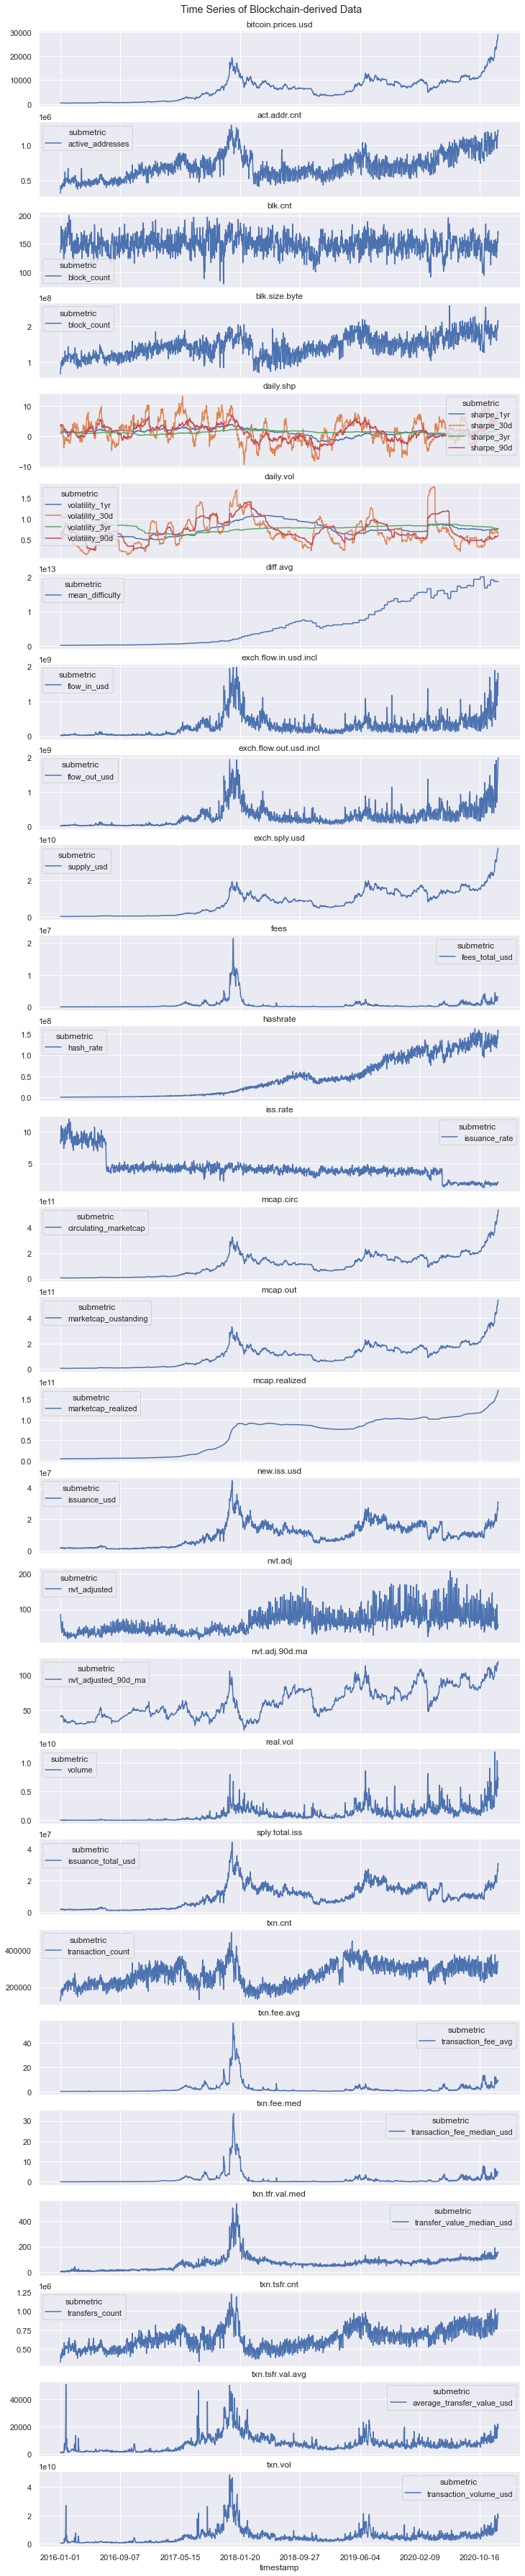

In [28]:
n_features = train_df['metric'].nunique()
ax_index = np.arange(1, n_features)
metric_features = train_df['metric'].unique().tolist()
metric_features.remove('price')

fig, ax = plt.subplots(nrows=n_features, ncols=1, sharex=True)
prices_train['close'].plot(ax=ax[0], title='bitcoin.prices.usd')

for metric, num in zip(metric_features, ax_index):
    wide_train[metric].plot(ax=ax[num], figsize=(12, n_features*2.3), title=metric)

fig.suptitle('Time Series of Blockchain-derived Data', y=0.888)
# fig.savefig('../raw/tsplot_train.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.888, 'Time Series of Blockchain-derived Data')

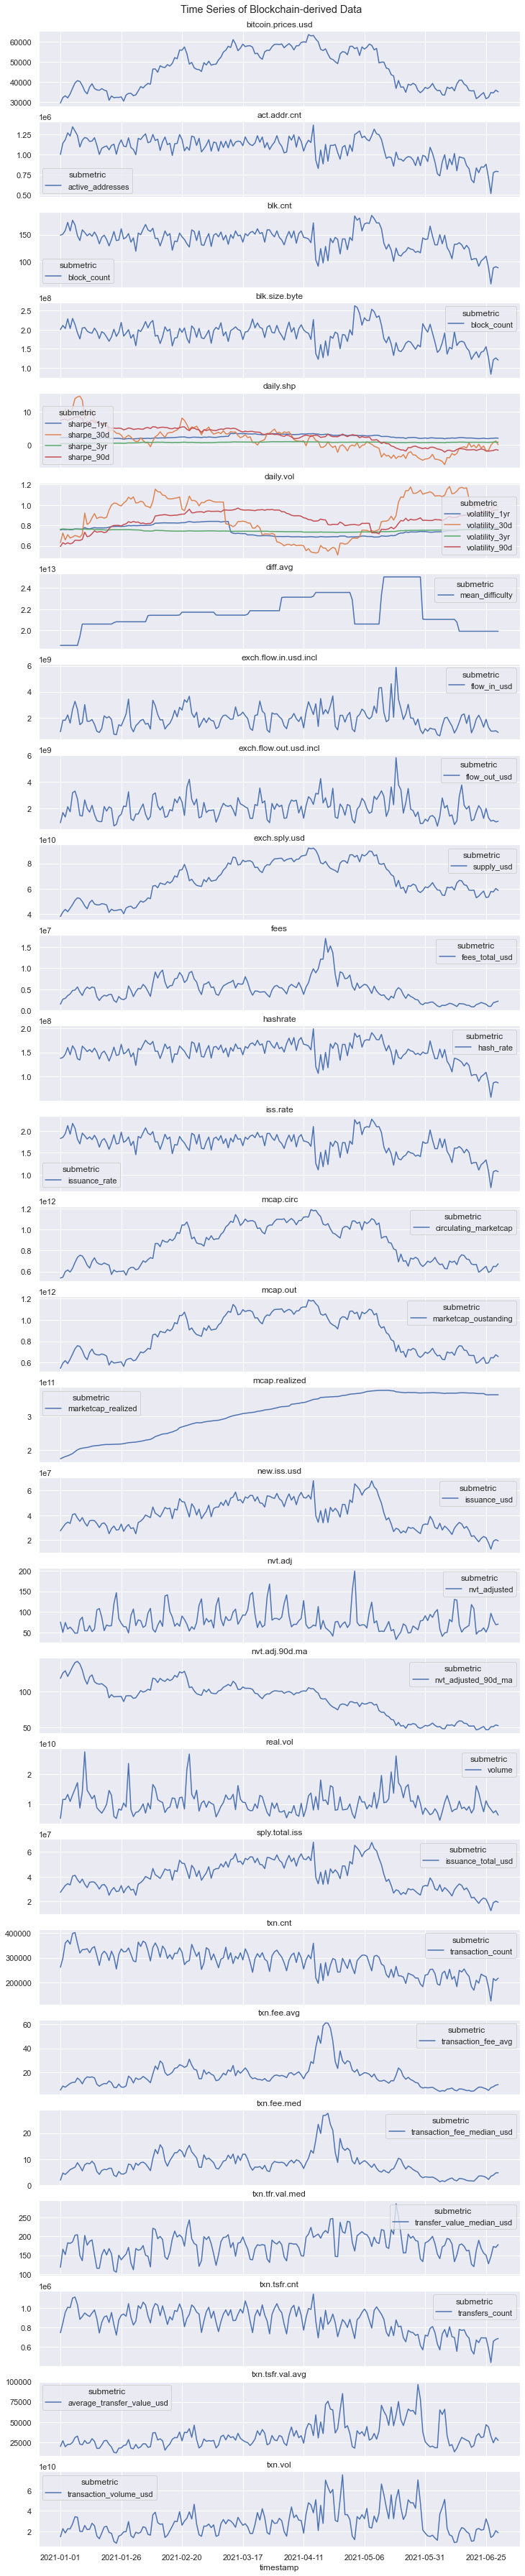

In [29]:
n_features = test_df['metric'].nunique()
ax_index = np.arange(1, n_features)
metric_features = test_df['metric'].unique().tolist()
metric_features.remove('price')

fig, ax = plt.subplots(nrows=n_features, ncols=1, sharex=True)
prices_test['close'].plot(ax=ax[0], title='bitcoin.prices.usd')

for metric, num in zip(metric_features, ax_index):
    wide_test[metric].plot(ax=ax[num], figsize=(12, n_features*2.3), title=metric)

fig.suptitle('Time Series of Blockchain-derived Data', y=0.888)
# fig.savefig('../raw/tsplot_test.png', dpi=300, bbox_inches='tight')

### Predictive Modeling

In [30]:
mainmodel = pipeline.ModelPipeline(ini_dir='../config/model.ini', section='DEFAULT')

In [31]:
xtrain, xtest = mainmodel.normalize(wide_train, wide_test)

In [32]:
xtrain, ytrain = mainmodel.create_dataset(xtrain, prices_train['close'], return_train_y=True)
xtest, ytest = mainmodel.create_dataset(xtest, prices_test['close'])

In [34]:
# Load weights from previous run
# mainmodel.reload()

In [36]:
mainmodel.model_train(xtrain, ytrain, xtest, ytest, verbose=0)